In [1]:
# Before proceeding run this cell (but if you have already install then ignore)
!pip install tensorflow==2.15.0
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install nltk

# Load Libraries

In [2]:
# dl packages
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud


# Load data

In [4]:
train_data = pd.read_csv("/content/train_data.csv", header=0, sep=",", names=["teks", "emosi"], encoding="utf-8")
test_data = pd.read_csv("/content/test_data.csv", header=0, sep=",", names=["teks", "emosi"], encoding="utf-8")
# get all words length in comment

data = pd.concat([train_data, test_data], ignore_index=True)
data['length'] = [len(x) for x in data['teks']]

In [5]:
data

,teks,emosi,length
0,saya merasa sangat sukses dalam kehidupan kelu...,senang,69
1,Saya tidak suka merasa diserang oleh sebuah la...,sedih,119
2,saya merasa artistik di href http bosan dengan...,senang,51
3,saya merasa seperti hidup tanpa pelengkap dan ...,senang,63
4,"Aku merasa sangat malu, takut hingga aku akan ...",sedih,164
...,...,...,...
19625,Saya sarankan menggunakannya sebelum mencuci d...,cinta,182
19626,saya tidak melihat atau merasa perlu untuk men...,sedih,98
19627,saya merasa sangat mati rasa dan fokus memikir...,sedih,82
19628,Saya memiliki lingkaran yang sangat sangat kec...,senang,129


In [6]:
data.shape

(19630, 3)

In [7]:
data.isnull().sum()

,0
teks,0
emosi,0
length,0


In [8]:
data.duplicated().sum()

1318

In [9]:
data = data.drop_duplicates()

In [10]:
data.shape

(18312, 3)

# EDA

In [11]:
data["length"].describe()

,length
count,18312.000000
mean,107.366263
std,67.052812
min,2.000000
25%,57.000000
50%,94.000000
75%,145.000000
max,503.000000


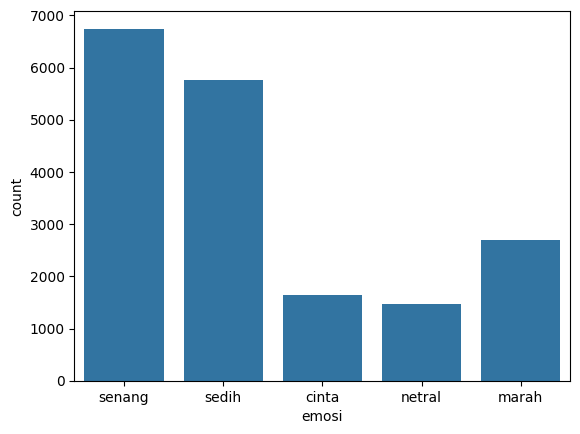

In [12]:
sns.countplot(x = data['emosi'])
plt.show()

# Data Preprocessing
# Encode emotions

In [13]:
lb = LabelEncoder()
data['emosi'] = lb.fit_transform(data['emosi'])

<ipython-input-13-b1b6a1bdb011>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['emosi'] = lb.fit_transform(data['emosi'])


In [14]:
data

,teks,emosi,length
0,saya merasa sangat sukses dalam kehidupan kelu...,4,69
1,Saya tidak suka merasa diserang oleh sebuah la...,3,119
2,saya merasa artistik di href http bosan dengan...,4,51
3,saya merasa seperti hidup tanpa pelengkap dan ...,4,63
4,"Aku merasa sangat malu, takut hingga aku akan ...",3,164
...,...,...,...
19625,Saya sarankan menggunakannya sebelum mencuci d...,0,182
19626,saya tidak melihat atau merasa perlu untuk men...,3,98
19627,saya merasa sangat mati rasa dan fokus memikir...,3,82
19628,Saya memiliki lingkaran yang sangat sangat kec...,4,129


# Applying Deep learning Using LSTM

# Text Cleaning, Encoding, and Padding

In [15]:
# Data cleaning and preprocessing
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('indonesian'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

data['teks_clean'] = data['teks'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-15-edef91a6425f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['teks_clean'] = data['teks'].apply(clean_text)


In [24]:
# Text cleaning function
def text_cleaning(data, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in data[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(data, "teks", vocab_size=11000, max_len=500)
y_train = to_categorical(data["emosi"])

# Model Building and Training

In [25]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=500))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 150)          1650000   
                                                                 
 dropout_3 (Dropout)         (None, 500, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=15, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/15
287/287 [==============================] - ETA: 0s - loss: 1.2261 - accuracy: 0.5070

287/287 [==============================] - 405s 1s/step - loss: 1.2261 - accuracy: 0.5070
Epoch 2/15
287/287 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.7665

287/287 [==============================] - 401s 1s/step - loss: 0.6640 - accuracy: 0.7665
Epoch 3/15
287/287 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.8302

287/287 [==============================] - 401s 1s/step - loss: 0.4937 - accuracy: 0.8302
Epoch 4/15
287/287 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8623

287/287 [==============================] - 402s 1s/step - loss: 0.4065 - accuracy: 0.8623
Epoch 5/15
287/287 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8824

287/287 [==============================] - 401s 1s/step - loss: 0.3459 - accuracy: 0.8824
Epoch 6/15
287/287 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.8977

287/287 [==============================] - 403s 1s/step - loss: 0.3077 - accuracy: 0.8977
Epoch 7/15
287/287 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.9054

287/287 [==============================] - 400s 1s/step - loss: 0.2801 - accuracy: 0.9054
Epoch 8/15
287/287 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.9141

287/287 [==============================] - 403s 1s/step - loss: 0.2564 - accuracy: 0.9141
Epoch 9/15
287/287 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9224

287/287 [==============================] - 404s 1s/step - loss: 0.2327 - accuracy: 0.9224
Epoch 10/15
287/287 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9300

287/287 [==============================] - 404s 1s/step - loss: 0.2113 - accuracy: 0.9300
Epoch 11/15
287/287 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9340

287/287 [==============================] - 401s 1s/step - loss: 0.2024 - accuracy: 0.9340
Epoch 12/15
287/287 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9373

287/287 [==============================] - 402s 1s/step - loss: 0.1884 - accuracy: 0.9373
Epoch 13/15
287/287 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9391

287/287 [==============================] - 400s 1s/step - loss: 0.1774 - accuracy: 0.9391
Epoch 14/15
287/287 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9453

287/287 [==============================] - 397s 1s/step - loss: 0.1630 - accuracy: 0.9453
Epoch 15/15
287/287 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9490

287/287 [==============================] - 402s 1s/step - loss: 0.1507 - accuracy: 0.9490


# Predictive System

In [32]:
# model = keras.models.load_model('model1.h5')

# Text cleaning function

# with open('lb1.pkl', 'rb') as f:
#     lb = pickle.load(f)

def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=500, padding='pre')
    return pad

# load model and predict
sentences = [
            "gue lagi baca buku",
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  model.predict(sentence)
    print(f"{result} : {proba}\n\n")

gue lagi baca buku
1/1 [==============================] - 0s 81ms/step
senang : [[0.02533055 0.02735956 0.02521255 0.31607956 0.60601777]]




# Save the model and files

In [33]:
import json
import pickle
# Save the model
model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 500}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

# Save model architecture in JSON format
model_json = model.to_json()  # Get the model architecture as a JSON string
with open("model1_architecture.json", "w") as json_file:
    json.dump(model_json, json_file)

In [34]:
# use this version
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

2.15.0
2.15.0
